# GPT-classifier

A fun experiment with few-shot learning to use GPT as a classifier.

## Instructions

- Running this will require API keys from OpenAI's GPT models. For security, I'm not able to share the keys I used here.
- This notebook contains all of the code and evaluation results for the few-shot learning experiment with GPT.


## Info
Datasets:
- Using the AG's News Topic Classification Dataset
- AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 
news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which 
has been running since July, 2004. 
- URL: https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv

Some stats:
```
$ wc -l ag_news_csv/*.csv
    7600 ag_news_csv/test.csv
  120000 ag_news_csv/train.csv
  127600 total
```


# Initial Prep

In [4]:
import pandas as pd

train_data = pd.read_csv('ag_news_csv/train.csv', header=None, names=['label', 'title', 'description'])
test_data = pd.read_csv('ag_news_csv/test.csv', header=None, names=['label', 'title', 'description'])

train_data

,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [5]:
test_data

,label,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [6]:
# sanity check
print(train_data['label'].value_counts(), '\n\n',
      test_data['label'].value_counts())

1    30000
2    30000
3    30000
4    30000
Name: label, dtype: int64 

 4    1900
1    1900
2    1900
3    1900
Name: label, dtype: int64


In [7]:
# Replace class values for model
train_data['label'] = train_data['label'].replace([1, 2, 3, 4], ['World', 'Sports', 'Business', 'Sci/Tech'])
test_data['label'] = test_data['label'].replace([1, 2, 3, 4], ['World', 'Sports', 'Business', 'Sci/Tech'])

# sanity check
print(train_data['label'].value_counts(), '\n\n',
      test_data['label'].value_counts())

Sports      30000
Business    30000
Sci/Tech    30000
World       30000
Name: label, dtype: int64 

 World       1900
Sci/Tech    1900
Business    1900
Sports      1900
Name: label, dtype: int64


# Classifier

In [1]:
import os
import openai
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import time
import tqdm as tqdm

# Pre-process Data
# # # # # # # # # #
train_data = pd.read_csv('ag_news_csv/train.csv', header=None, names=['label', 'title', 'description'])
test_data = pd.read_csv('ag_news_csv/test.csv', header=None, names=['label', 'title', 'description'])

# Replace class values for model
train_data['label'] = train_data['label'].replace([1, 2, 3, 4], ['World', 'Sports', 'Business', 'Sci/Tech'])
test_data['label'] = test_data['label'].replace([1, 2, 3, 4], ['World', 'Sports', 'Business', 'Sci/Tech'])

# Select a few head samples for few-shot learning prompt
fewshot_prompt = ""
num_samples = 2
for lb in ['World', 'Sports', 'Business', 'Sci/Tech']:
    train_data_lbset = train_data[ train_data['label'] == lb ]
    for n in range(num_samples):
        fewshot_prompt_subset = "- {} | {} | {}\n".format(train_data_lbset.iloc[n]['label'], 
                                                          train_data_lbset.iloc[n]['title'],
                                                          train_data_lbset.iloc[n]['description'])
        fewshot_prompt += fewshot_prompt_subset



# GPT
# # # # # # # # # #
openai.api_key = open('.api_key').read().strip()  # Use os.getenv("OPENAI_API_KEY") also possible

def gpt_query(test_prompt):
    prompt = """You are an expert at text classification. Here are some examples of different classes, the news article titles, and descriptions separated by "|":\n
    -----\n
    {fewshot_prompt}
    -----\n
    What is the class for this news article title and description from the options
    'World', 'Sports', 'Business', 'Sci/Tech'?:\n
    {test_prompt}
    \n\nClass:
    """.format(fewshot_prompt=fewshot_prompt,
               test_prompt=test_prompt)

    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        temperature=0.7,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )    
    gpt_response = response["choices"][0]["text"].strip()
    return gpt_response


# Format test set
# # # # # # # # # #
# test_data_subset = test_data[:5]  # Subset of test leads to imbalanced test set

num_test_samples = 25
X_test = []
y_test = []
for lb in ['World', 'Sports', 'Business', 'Sci/Tech']:
    test_data_lbset = test_data[ test_data['label'] == lb ]
    for n in range(num_test_samples):
        test_prompt_n = "{} | {}".format(test_data_lbset.iloc[n]['title'],
                                         test_data_lbset.iloc[n]['description'])
        X_test.append(test_prompt_n)
        y_test.append(test_data_lbset.iloc[n]['label'])

# Shuffle rows consistently
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# Query
gpt_test_output = []

for pt in tqdm.tqdm(X_test):
    gpt_output = gpt_query(pt)
    gpt_test_output.append(gpt_output)
    time.sleep(2)

# print(gpt_test_output)

100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


In [2]:
y_test

['Sports',
 'Sci/Tech',
 'World',
 'Business',
 'Sci/Tech',
 'Sci/Tech',
 'World',
 'Business',
 'Business',
 'Sci/Tech',
 'Business',
 'Sci/Tech',
 'Sci/Tech',
 'World',
 'World',
 'Sports',
 'World',
 'World',
 'Sports',
 'World',
 'Sports',
 'Business',
 'World',
 'Business',
 'Sports',
 'Sports',
 'World',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Business',
 'Sci/Tech',
 'Sci/Tech',
 'Business',
 'Business',
 'Sports',
 'World',
 'Business',
 'Business',
 'Business',
 'World',
 'Business',
 'Sports',
 'Sports',
 'World',
 'World',
 'World',
 'Sports',
 'Sports',
 'World',
 'Sci/Tech',
 'Business',
 'World',
 'Sports',
 'Sports',
 'Business',
 'World',
 'Sports',
 'World',
 'Business',
 'World',
 'Sports',
 'Business',
 'Business',
 'Sci/Tech',
 'Sci/Tech',
 'Sports',
 'Sci/Tech',
 'World',
 'Sci/Tech',
 'World',
 'Sports',
 'Sports',
 'Sci/Tech',
 'Sci/Tech',
 'Business',
 'World',
 'Sci/Tech',
 'Business',
 'Sci/Tech',
 'Sports',
 'Sports',
 'Sci/Tech',
 'Sports',
 'Sports',
 'Bus

Acc.  0.82


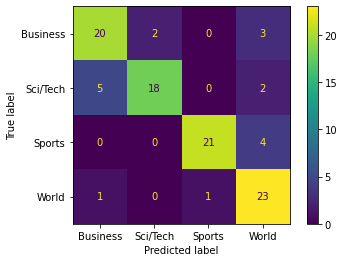

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_true = y_test
y_pred = gpt_test_output

print("Acc. ", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Business', 'Sci/Tech', 'Sports', 'World'])
disp.plot()
plt.show()